In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset,TensorDataset
from autoencoder import Autoencoder
from cifar_autoencoder import Cifar_Autoencoder
import torchvision
from model2 import classification_model
from model import cifar_classification_model
import copy
import partition
from pca import PCADigitReducer
from autoencoder import reduce_dimensions
from training import train,test
from federated_learning import distribute_global_model, federated_averaging

In [66]:
# Predefined stuff

n_epochs = 17
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
num_clusters = 2

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

Mean: tensor([0.4914, 0.4822, 0.4465])
Std: tensor([0.2023, 0.1994, 0.2010])

In [68]:
cifar10_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Precomputed mean and std for CIFAR-10
])

cifar10_train_loader = DataLoader(
    datasets.CIFAR10('/files/', train=True, download=True, transform=cifar10_transform),
    batch_size=batch_size_train, shuffle=True
)

cifar10_test_loader = DataLoader(
    datasets.CIFAR10('/files/', train=False, download=True, transform=cifar10_transform),
    batch_size=batch_size_test, shuffle=True
)

Files already downloaded and verified
Files already downloaded and verified


In [70]:
for data, target in cifar10_train_loader:
    print(f"Data batch size: {data.size(0)}, Target batch size: {target.size(0)}")
    break

Data batch size: 64, Target batch size: 64


In [72]:
class CustomTensorDataset(TensorDataset):
    def __init__(self, *tensors):
        super().__init__(*tensors)
        self.data = tensors[0]
        self.targets = tensors[1]

In [74]:
train_loader_pca = copy.copy(cifar10_train_loader)
test_loader_pca = copy.copy(cifar10_test_loader)

train_loader_auto = copy.copy(cifar10_train_loader)
test_loader_auto = copy.copy(cifar10_test_loader)

In [76]:
print((cifar10_train_loader.dataset))

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /files/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )


In [78]:
train_data = []
train_labels = []
for data, labels in train_loader_pca:  # Use your CIFAR-10 DataLoader here
    train_data.append(data.view(data.size(0), -1))  # Flatten images
    train_labels.append(labels)
train_data = torch.cat(train_data, dim=0)  # Combine all batches
train_labels = torch.cat(train_labels, dim=0)

# Convert to numpy for PCA
train_data_np = train_data.numpy()

# Perform PCA
n_components = 100  # Set the desired number of components
pca = PCADigitReducer(n_components)
train_data_reduced = pca.fit_transform(train_data_np)  # Reduce dimensions

# Reconstruct the dataset from the reduced dimensions
train_data_reconstructed_np = pca.inverse_transform(train_data_reduced) 
train_data_reconstructed = torch.tensor(train_data_reconstructed_np, dtype=torch.float32)

# Reshape the reconstructed data back into the original image dimensions
train_data_reconstructed = train_data_reconstructed.view(-1, 3, 32, 32)

# Normalize the reconstructed dataset (use CIFAR-10 mean and std)
train_data_reconstructed = (train_data_reconstructed - torch.tensor([0.4914, 0.4822, 0.4465]).view(1, 3, 1, 1)) / \
                           torch.tensor([0.2470, 0.2435, 0.2616]).view(1, 3, 1, 1)

# Create a new DataLoader for the reconstructed data
batch_size_train = cifar10_train_loader.batch_size
train_dataset_pca = CustomTensorDataset(train_data_reconstructed, train_labels)
train_loader_reduced_pca = DataLoader(train_dataset_pca, batch_size=batch_size_train, shuffle=True)

In [79]:
trainingset_pca = train_loader_reduced_pca.dataset

print(trainingset_pca.targets)

tensor([7, 1, 1,  ..., 0, 5, 9])


In [80]:
latent_dim = 100  # Adjust latent dimension as needed
autoencoder = Cifar_Autoencoder(latent_dim=latent_dim)
auto_criterion = nn.MSELoss()
auto_optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
auto_num_epochs = 5

for epoch in range(auto_num_epochs):
    for images, _ in cifar10_train_loader:  # Use your CIFAR-10 DataLoader here
        auto_optimizer.zero_grad()
        
        # Forward pass
        reconstructed = autoencoder(images)
        
        # Compute reconstruction loss
        loss = auto_criterion(reconstructed, images)
        
        # Backward pass and optimization
        loss.backward()
        auto_optimizer.step()
        
    print(f"Epoch [{epoch+1}/{auto_num_epochs}], Loss: {loss.item()}")


Epoch [1/5], Loss: 1.0315274000167847
Epoch [2/5], Loss: 0.8774186968803406
Epoch [3/5], Loss: 0.8388128280639648
Epoch [4/5], Loss: 0.9051497578620911
Epoch [5/5], Loss: 0.8178097605705261


In [81]:
autoencoder.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
latent_features, labels = reduce_dimensions(train_loader_auto, autoencoder.encoder, device)
latent_features = latent_features.detach()

reconstructed_images = autoencoder.decoder(latent_features.to(device))  
reconstructed_images = reconstructed_images.view(-1, 3, 32, 32) # Reshape to [batch_size, channels, height, width]

reconstructed_dataset = CustomTensorDataset(reconstructed_images.cpu(), labels)  
reduced_train_loader_auto = DataLoader(reconstructed_dataset, batch_size=batch_size_train, shuffle=True)

In [85]:
numberOfPartitions = [4, 6, 8, 10]
results = {"classic": {}, "pca": {}, "autoencoder": {}}
clusteredResults = {"classic": {}, "pca": {}, "autoencoder": {}}

In [87]:
trainingset = cifar10_train_loader.dataset
global_model_classic =cifar_classification_model()

In [ ]:
for partitions_number in numberOfPartitions:
    print(f"Running experiment with {partitions_number} partitions...")

    partitioned_data_classic = partition.balanced_dirichlet_partition(trainingset, partitions_number=partitions_number, alpha=0.5)

    classic_client_loaders = [
        DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_classic.values()
    ]

    num_clients = partitions_number
    local_models_classic = [copy.deepcopy(gloabl_model_classic) for _ in range(num_clients)]

    rounds_classic = 4
    
    for round_idx in range(rounds_classic):
        
        print(f"Round {round_idx + 1}/{rounds_classic}")
    
        local_weights_classic = []
        for client_idx, client_model in enumerate(local_models_classic):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                          momentum=momentum)
    
            train_losses = []
            train_counter = []
    
            for epoch in range(1, n_epochs + 1):  
                train(epoch, client_model, classic_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_classic.append(client_weights)
            
        print(f"after training{local_models_classic}")
        global_weights_classic = federated_averaging(local_weights_classic)
        print(f"after fedaveraging{local_models_classic}")
    
        distribute_global_model(global_weights_classic,local_models_classic,single=False)
    
        distribute_global_model(global_weights_classic,gloabl_model_classic,single=True)
        test_losses = []
        test(gloabl_model_classic,cifar10_test_loader,test_losses)

        test_accuracies_classic = []
        correct = 0
        with torch.no_grad():
            for data, target in cifar10_test_loader:
                output = global_model_classic(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(cifar10_test_loader.dataset)
        test_accuracies_classic.append(accuracy)

        # Save results for non-clustered classic
        if partitions_number not in results["classic"]:
            results["classic"][partitions_number] = {"losses": [], "accuracy": []}

        results["classic"][partitions_number]["losses"].extend(test_losses)
        results["classic"][partitions_number]["accuracy"].extend(test_accuracies_classic)

    ######################
    import cluster
    
    cluster = cluster.Cluster(num_clusters=num_clusters)
    
    targets = trainingset.targets
    num_classes = len(set(targets)) 
    clustered_data = cluster.apply_clustering(partitioned_data_classic, targets, num_classes)
    
    partitioned_data_classic = clustered_data

    classic_client_loaders_clustered = [
        DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_classic.values()
    ]

    for round_idx in range(rounds_classic):
        
        print(f"Round {round_idx + 1}/{rounds_classic}")
    
        local_weights_classic = []
        for client_idx, client_model in enumerate(local_models_classic[0:num_clusters]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                          momentum=momentum)
    
            train_losses = []
            train_counter = []
    
            for epoch in range(1, n_epochs + 1):  
                train(epoch, client_model, classic_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_classic.append(client_weights)
            
        print(f"after training{local_models_classic}")
        global_weights_classic = federated_averaging(local_weights_classic)
        print(f"after fedaveraging{local_models_classic}")
    
        distribute_global_model(global_weights_classic,local_models_classic,single=False)
    
        distribute_global_model(global_weights_classic,gloabl_model_classic,single=True)
        test_losses = []
        test(gloabl_model_classic,cifar10_test_loader,test_losses)

        test_accuracies_classic = []
        correct = 0
        with torch.no_grad():
            for data, target in cifar10_test_loader:
                output = global_model_classic(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(cifar10_test_loader.dataset)
        test_accuracies_classic.append(accuracy)

        # Save results for clustered classic
        if partitions_number not in clusteredResults["classic"]:
            clusteredResults["classic"][partitions_number] = {"losses": [], "accuracy": []}

        clusteredResults["classic"][partitions_number]["losses"].extend(test_losses)
        clusteredResults["classic"][partitions_number]["accuracy"].extend(test_accuracies_classic)

Running experiment with 4 partitions...
Round 1/4
Training client 1
Train Epoch: 1 [0/18580 (0%)]	Loss: 1.355282
Train Epoch: 1 [640/18580 (3%)]	Loss: 1.261674
Train Epoch: 1 [1280/18580 (7%)]	Loss: 1.151928
Train Epoch: 1 [1920/18580 (10%)]	Loss: 1.059240
Train Epoch: 1 [2560/18580 (14%)]	Loss: 1.057697
Train Epoch: 1 [3200/18580 (17%)]	Loss: 1.143603
Train Epoch: 1 [3840/18580 (21%)]	Loss: 0.983513
Train Epoch: 1 [4480/18580 (24%)]	Loss: 0.984886
Train Epoch: 1 [5120/18580 (27%)]	Loss: 1.235176
Train Epoch: 1 [5760/18580 (31%)]	Loss: 1.288556
Train Epoch: 1 [6400/18580 (34%)]	Loss: 0.987643
Train Epoch: 1 [7040/18580 (38%)]	Loss: 0.833869
Train Epoch: 1 [7680/18580 (41%)]	Loss: 1.190640
Train Epoch: 1 [8320/18580 (45%)]	Loss: 1.022397
Train Epoch: 1 [8960/18580 (48%)]	Loss: 1.160860
Train Epoch: 1 [9600/18580 (52%)]	Loss: 0.999658
Train Epoch: 1 [10240/18580 (55%)]	Loss: 1.392760
Train Epoch: 1 [10880/18580 (58%)]	Loss: 1.003927
Train Epoch: 1 [11520/18580 (62%)]	Loss: 0.943866
Train

In [ ]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

In [ ]:
# PCA 
trainingset_pca = train_loader_reduced_pca.dataset
global_model_pca = cifar_classification_model()

In [ ]:
for partitions_number in numberOfPartitions:
    print(f"Running experiment with {partitions_number} partitions...")

    partitioned_data_pca = partition.balanced_dirichlet_partition(trainingset_pca, partitions_number=partitions_number, alpha=0.5)

    pca_client_loaders = [
        DataLoader(Subset(trainingset_pca, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_pca.values()
    ]

    num_clients = partitions_number
    local_models_pca = [copy.deepcopy(global_model_pca) for _ in range(num_clients)]

    rounds_pca = 4
    
    for round_idx in range(rounds_pca):
        
        print(f"Round {round_idx + 1}/{rounds_pca}")
    
        local_weights_pca = []
        for client_idx, client_model in enumerate(local_models_pca):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                          momentum=momentum)
    
            train_losses = []
            train_counter = []
    
    
            for epoch in range(1, n_epochs + 1):  
                train(epoch, client_model, pca_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_pca.append(client_weights)
            
        print(f"after training{local_models_pca}")
        global_weights_pca = federated_averaging(local_weights_pca)
        print(f"after fedaveraging{local_models_pca}")
    
        distribute_global_model(global_weights_pca,local_models_pca,single=False)
    
        distribute_global_model(global_weights_pca,global_model_pca,single=True)
        test_losses = []
        test(global_model_pca,test_loader_pca,test_losses)

        test_accuracies_classic = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader_pca:
                output = global_model_pca(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader_pca.dataset)
        test_accuracies_classic.append(accuracy)

        # Save results for non-clustered classic
        if partitions_number not in results["pca"]:
            results["pca"][partitions_number] = {"losses": [], "accuracy": []}

        results["pca"][partitions_number]["losses"].extend(test_losses)
        results["pca"][partitions_number]["accuracy"].extend(test_accuracies_classic)

    ######################
    import cluster
    
    cluster = cluster.Cluster(num_clusters=num_clusters)
    
    targets = trainingset_pca.targets
    num_classes = len(set(targets)) 
    clustered_data = cluster.apply_clustering(partitioned_data_pca, targets, num_classes)
    
    partitioned_data_pca = clustered_data

    pca_client_loaders = [
        DataLoader(Subset(trainingset_pca, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_pca.values()
    ]

    for round_idx in range(rounds_pca):
        
        print(f"Round {round_idx + 1}/{rounds_pca}")
    
        local_weights_pca = []
        for client_idx, client_model in enumerate(local_models_pca[0:num_clusters]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                          momentum=momentum)
    
            train_losses = []
            train_counter = []
    
    
            for epoch in range(1, n_epochs + 1):  
                train(epoch, client_model, pca_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_pca.append(client_weights)
            
        print(f"after training{local_models_pca}")
        global_weights_pca = federated_averaging(local_weights_pca)
        print(f"after fedaveraging{local_models_pca}")
    
        distribute_global_model(global_weights_pca,local_models_pca,single=False)
    
        distribute_global_model(global_weights_pca,global_model_pca,single=True)
        test_losses = []
        test(global_model_pca,test_loader_pca,test_losses)

        test_accuracies_classic = []
        correct = 0
        with torch.no_grad():
            for data, target in cifar10_test_loader:
                output = global_model_pca(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(cifar10_test_loader.dataset)
        test_accuracies_classic.append(accuracy)

        # Save results for clustered classic
        if partitions_number not in clusteredResults["pca"]:
            clusteredResults["pca"][partitions_number] = {"losses": [], "accuracy": []}

        clusteredResults["pca"][partitions_number]["losses"].extend(test_losses)
        clusteredResults["pca"][partitions_number]["accuracy"].extend(test_accuracies_classic)

Running experiment with 4 partitions...
Round 1/4
Training client 1
Train Epoch: 1 [0/18580 (0%)]	Loss: 1.675059
Train Epoch: 1 [640/18580 (3%)]	Loss: 1.499663
Train Epoch: 1 [1280/18580 (7%)]	Loss: 1.374220
Train Epoch: 1 [1920/18580 (10%)]	Loss: 1.552220
Train Epoch: 1 [2560/18580 (14%)]	Loss: 1.513763
Train Epoch: 1 [3200/18580 (17%)]	Loss: 1.227091
Train Epoch: 1 [3840/18580 (21%)]	Loss: 1.544225
Train Epoch: 1 [4480/18580 (24%)]	Loss: 1.379683
Train Epoch: 1 [5120/18580 (27%)]	Loss: 1.312937
Train Epoch: 1 [5760/18580 (31%)]	Loss: 1.042081
Train Epoch: 1 [6400/18580 (34%)]	Loss: 1.296115
Train Epoch: 1 [7040/18580 (38%)]	Loss: 1.345790
Train Epoch: 1 [7680/18580 (41%)]	Loss: 1.619032
Train Epoch: 1 [8320/18580 (45%)]	Loss: 1.355864
Train Epoch: 1 [8960/18580 (48%)]	Loss: 1.312147
Train Epoch: 1 [9600/18580 (52%)]	Loss: 1.422444
Train Epoch: 1 [10240/18580 (55%)]	Loss: 1.140339
Train Epoch: 1 [10880/18580 (58%)]	Loss: 1.367297
Train Epoch: 1 [11520/18580 (62%)]	Loss: 1.442487
Train

In [ ]:
#Auto
trainingset_auto = reduced_train_loader_auto.dataset
global_model_auto = cifar_classification_model()

In [97]:
for partitions_number in numberOfPartitions:
    print(f"Running experiment with {partitions_number} partitions...")

    partitioned_data_auto = partition.balanced_dirichlet_partition(trainingset_auto, partitions_number=partitions_number, alpha=0.5)

    auto_client_loaders = [
        DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_auto.values()
    ]

    num_clients = partitions_number
    local_model_autoencoder = [copy.deepcopy(global_model_pca) for _ in range(num_clients)]

    rounds_auto = 4
    
    for round_idx in range(rounds_auto):
        print(f"Round {round_idx + 1}/{rounds_auto}")
    
        local_weights_auto = []
        for client_idx, client_model in enumerate(local_model_autoencoder):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                          momentum=momentum)
            
            train_losses = []
            train_counter = []
    
            for epoch in range(1, n_epochs + 1):  
                train(epoch, client_model, auto_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_auto.append(client_weights)
            
        global_weights_auto = federated_averaging(local_weights_auto)
    
        distribute_global_model(global_weights_auto,local_model_autoencoder,single=False)
    
        distribute_global_model(global_weights_auto, global_model_auto,single=True)
        test_losses = []
        test(global_model_auto,test_loader_auto,test_losses)

        test_accuracies_classic = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader_pca:
                output = global_model_auto(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader_pca.dataset)
        test_accuracies_classic.append(accuracy)

        # Save results for non-clustered classic
        if partitions_number not in results["autoencoder"]:
            results["autoencoder"][partitions_number] = {"losses": [], "accuracy": []}

        results["autoencoder"][partitions_number]["losses"].extend(test_losses)
        results["autoencoder"][partitions_number]["accuracy"].extend(test_accuracies_classic)

    ######################
    import cluster
    
    cluster = cluster.Cluster(num_clusters=num_clusters)
    
    targets = trainingset_pca.targets
    num_classes = len(set(targets)) 
    clustered_data = cluster.apply_clustering(partitioned_data_pca, targets, num_classes)
    
    partitioned_data_pca = clustered_data

    auto_client_loaders = [
        DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_auto.values()
    ]

    
    for round_idx in range(rounds_auto):
        print(f"Round {round_idx + 1}/{rounds_auto}")
    
        local_weights_auto = []
        for client_idx, client_model in enumerate(local_model_autoencoder[0:num_clusters]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                          momentum=momentum)
            
            train_losses = []
            train_counter = []
    
            for epoch in range(1, n_epochs + 1):  
                train(epoch, client_model, auto_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_auto.append(client_weights)
            
        global_weights_auto = federated_averaging(local_weights_auto)
    
        distribute_global_model(global_weights_auto,local_model_autoencoder,single=False)
    
        distribute_global_model(global_weights_auto, global_model_auto,single=True)
        test_losses = []
        test(global_model_auto,test_loader_auto,test_losses)

        test_accuracies_classic = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader_auto:
                output = global_model_auto(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader_auto.dataset)
        test_accuracies_classic.append(accuracy)

        # Save results for clustered classic
        if partitions_number not in clusteredResults["autoencoder"]:
            clusteredResults["autoencoder"][partitions_number] = {"losses": [], "accuracy": []}

        clusteredResults["autoencoder"][partitions_number]["losses"].extend(test_losses)
        clusteredResults["autoencoder"][partitions_number]["accuracy"].extend(test_accuracies_classic)

Train Epoch: 14 [7680/9043 (85%)]	Loss: 1.633244
Train Epoch: 14 [8320/9043 (92%)]	Loss: 1.449955
Train Epoch: 14 [8960/9043 (99%)]	Loss: 1.394827
Train Epoch: 15 [0/9043 (0%)]	Loss: 1.405419
Train Epoch: 15 [640/9043 (7%)]	Loss: 1.732412
Train Epoch: 15 [1280/9043 (14%)]	Loss: 1.198173
Train Epoch: 15 [1920/9043 (21%)]	Loss: 1.711638
Train Epoch: 15 [2560/9043 (28%)]	Loss: 1.616006
Train Epoch: 15 [3200/9043 (35%)]	Loss: 1.477225
Train Epoch: 15 [3840/9043 (42%)]	Loss: 1.545780
Train Epoch: 15 [4480/9043 (49%)]	Loss: 1.442973
Train Epoch: 15 [5120/9043 (56%)]	Loss: 1.331815
Train Epoch: 15 [5760/9043 (63%)]	Loss: 1.490621
Train Epoch: 15 [6400/9043 (70%)]	Loss: 1.517512
Train Epoch: 15 [7040/9043 (77%)]	Loss: 1.584181
Train Epoch: 15 [7680/9043 (85%)]	Loss: 1.416431
Train Epoch: 15 [8320/9043 (92%)]	Loss: 1.486871
Train Epoch: 15 [8960/9043 (99%)]	Loss: 1.488230
Train Epoch: 16 [0/9043 (0%)]	Loss: 1.334935
Train Epoch: 16 [640/9043 (7%)]	Loss: 1.319610
Train Epoch: 16 [1280/9043 (14%)

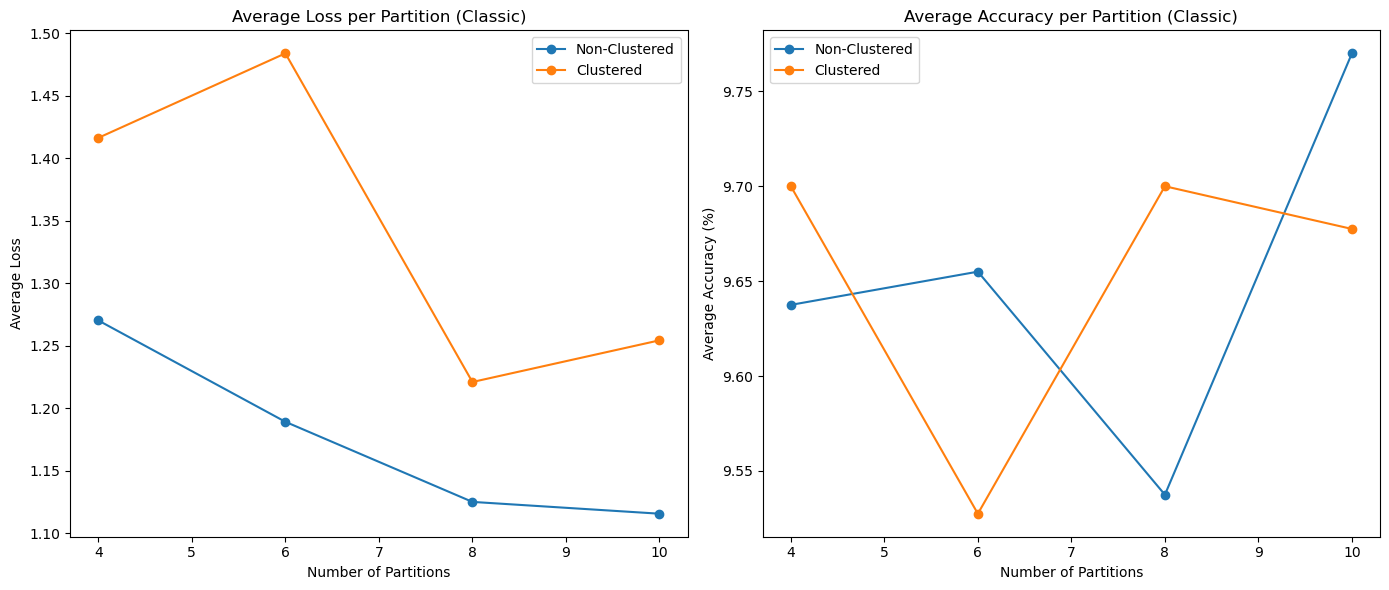

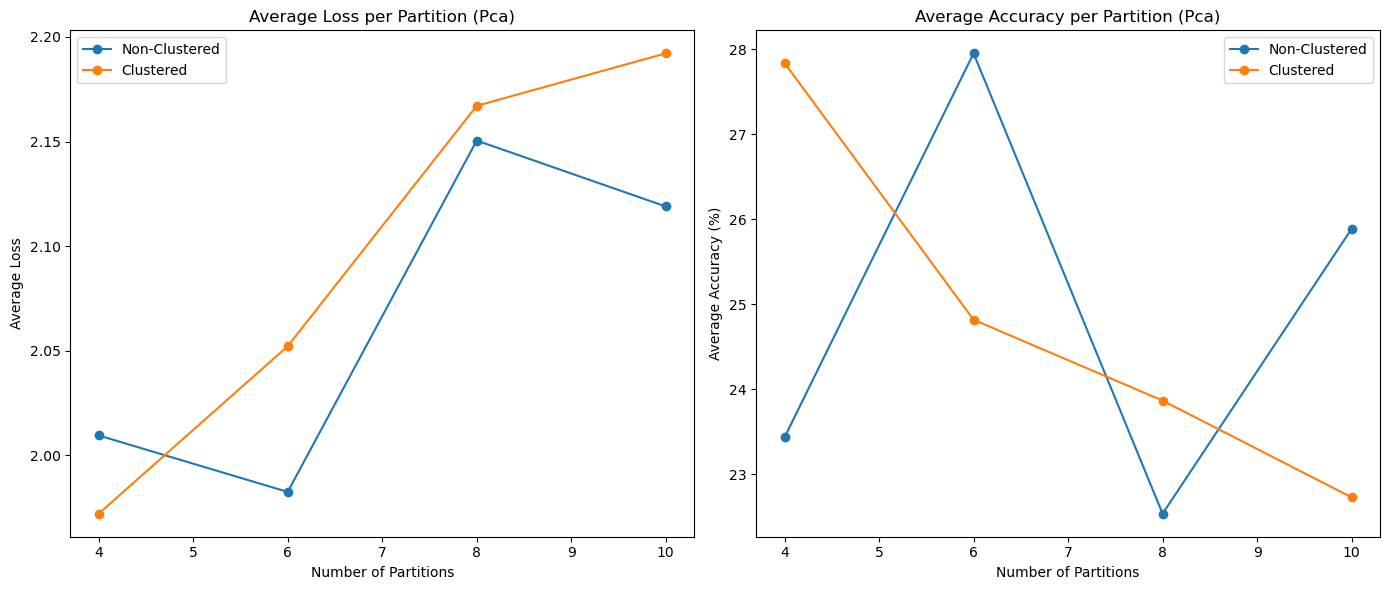

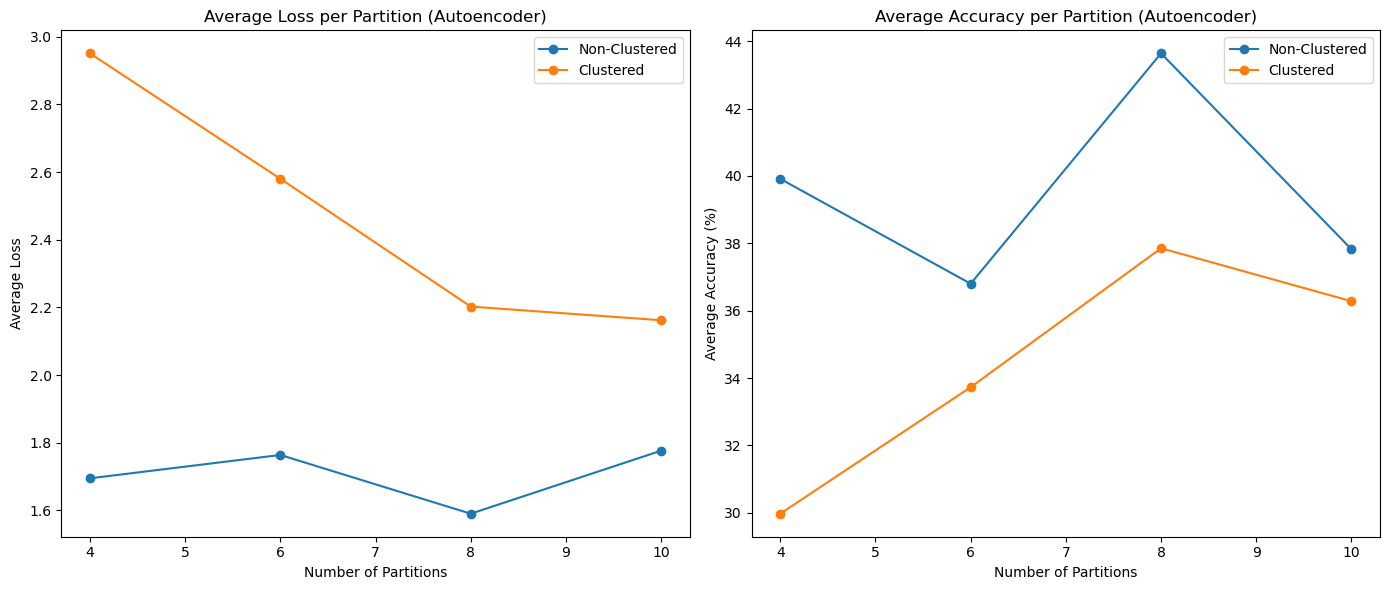

In [99]:
import matplotlib.pyplot as plt

def calculate_client_averages(data):
    client_averages = {}
    for client, client_data in data.items():  
        client_averages[client] = {}
        for partition_number, metrics in client_data.items():  # Iterate over partitions
            avg_loss = sum(metrics['losses']) / len(metrics['losses']) if metrics['losses'] else 0
            avg_accuracy = sum(metrics['accuracy']) / len(metrics['accuracy']) if metrics['accuracy'] else 0
            client_averages[client][partition_number] = {"average_loss": avg_loss, "average_accuracy": avg_accuracy}
    return client_averages


non_clustered_averages = calculate_client_averages(results)
clustered_averages = calculate_client_averages(clusteredResults)


def plot_averages(non_clustered, clustered):
    for client_type in non_clustered.keys(): 
        partitions_non_clustered = list(non_clustered[client_type].keys())
        losses_non_clustered = [
            non_clustered[client_type][partition]["average_loss"] for partition in partitions_non_clustered
        ]
        accuracies_non_clustered = [
            non_clustered[client_type][partition]["average_accuracy"] for partition in partitions_non_clustered
        ]

        partitions_clustered = list(clustered[client_type].keys())
        losses_clustered = [
            clustered[client_type][partition]["average_loss"] for partition in partitions_clustered
        ]
        accuracies_clustered = [
            clustered[client_type][partition]["average_accuracy"] for partition in partitions_clustered
        ]

        plt.figure(figsize=(14, 6))

 
        plt.subplot(1, 2, 1)
        plt.plot(partitions_non_clustered, losses_non_clustered, label="Non-Clustered", marker="o")
        plt.plot(partitions_clustered, losses_clustered, label="Clustered", marker="o")
        plt.xlabel("Number of Partitions")
        plt.ylabel("Average Loss")
        plt.title(f"Average Loss per Partition ({client_type.capitalize()})")
        plt.legend()

 
        plt.subplot(1, 2, 2)
        plt.plot(partitions_non_clustered, accuracies_non_clustered, label="Non-Clustered", marker="o")
        plt.plot(partitions_clustered, accuracies_clustered, label="Clustered", marker="o")
        plt.xlabel("Number of Partitions")
        plt.ylabel("Average Accuracy (%)")
        plt.title(f"Average Accuracy per Partition ({client_type.capitalize()})")
        plt.legend()

        plt.tight_layout()
        plt.show()

# Plot averages for all client types
plot_averages(non_clustered_averages, clustered_averages)